### Demo Kernel
This notebook contains the steps to reproduce the experiment results of ***fair kernel regression with multiple sensitive attributes*** on **Communities & Crime** dataset.

#### Step 1: Include Packages and Set Up Global Parameters 

In [ ]:
import numpy as np
import pandas as pd
import data_parser as parser
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from fair_reg import MP_Fair_regression, MP_Penalty_regression, Fair_kernel_learning
from utils import subsample, train_test_split_groups, fix_random, SMD, gen_idx, generate_data, record_results

# Global Variables
TEST_SIZE = 0.2  # fraction of observations from each protected group
DATA_SPLIT_SEED = 4
RANDOM_SEED = 0
fix_random(RANDOM_SEED)

#### Step 2: Experiment Setting
Here we consider kernel regression with multiple binary sensitive attributes. 

The following four hyper-parameters are needed (See Section 2.1 for more details):
* $m$:  number of dimensions for protected attributes, e.g., 1 for signle attribute like {gender}, 2 for two attributes like {gender, race}
* $k$:  number of possible values in protected attributes (the cardinality of $\Omega_S$)
* kernel_xs: $\kappa_{XS}$, the kernel for regression
* kernel_s: $\kappa_S$, the kernel for the sensitive attributes

In this notebook, we consider regression using rbf kernel with $m \in \{1,2,3,4,5\}$ with $k=2^m$.

In [ ]:
lmd = 1
gamma = 0.1
kernel_xs = lambda X,Y: sklearn.metrics.pairwise.rbf_kernel(X,Y, gamma = gamma)

#### Step 3: Run Experiment for Each Dataset

In [ ]:
dataset = 'Communities'
sens_attributes = ['race','medIncome', 'householdsize', 'medFamInc']
sens_thres = 0.5 # threshold for converting attributes to binary value 
n_trail = 10 # Number of trails for each experiment

## Create a dataframe for recording the experiment results
df = pd.DataFrame(columns=['Model', 'Dataset', 'Mode', 'MSE', 'SMD', 'K'])

for num_sens in range(1,5):
    # Decide kappa_s
    m = num_sens
    k = 2**m 
    other_info = {'K':k}
    # For kappa_s, polynomial_kernel with degree  is recommended.
    kernel_s = lambda X, Y: sklearn.metrics.pairwise.polynomial_kernel(X, Y, degree=k, gamma=None, coef0=1) 
    
    for DATA_SPLIT_SEED  in range(n_trail):
        ############################################################
        ################    Data Preprocessing   ###################
        ############################################################
     
        # Race in [0,1] as protected attribute.
        x, _, y = parser.clean_communities_full()
        
        for sd in sens_attributes:
            x.loc[x[sd]>=sens_thres, sd]=1
            x.loc[x[sd]<sens_thres, sd]=0

        s = x[sens_attributes[0:num_sens]]

        ## Convert to numpy array
        x = np.array(x)
        s = np.array(s).reshape([-1, len(sens_attributes[0:num_sens])])
        y = np.array(y).reshape([-1, 1])
        
        # Shuffle the data for splitting
        num_shuffle = x.shape[0]
        index_shuffle = np.random.permutation(num_shuffle)

        train_size = int(x.shape[0]*(1-TEST_SIZE))

        x = x[index_shuffle, :]
        s = s[index_shuffle, :]
        y = y[index_shuffle, :]

        # Train/Test Split
        x_val = x[train_size:,:]
        s_val = s[train_size:,:]
        y_val = y[train_size:,:]

        x = x[0:train_size,:]
        s = s[0:train_size,:]
        y = y[0:train_size,:]
        
        # Centeralized
        y_mean = np.mean(y)
        y = y - y_mean
        y_val = y_val - y_mean
        
        # Add intercept column
        x = np.c_[x, np.ones_like(y)]
        x_val = np.c_[x_val, np.ones_like(y_val)]
        
        ### Generate indicators for each sensitive group.
        ### NOTE: We assume that each attribute has only binary value, i.e. 0 or 1. 
        ### If your data has other values, you should generate the indicator for each sensitive group by yourself.
        
        # Train Set
        idx_set = gen_idx(s, num_sens = m, s_0 = 0, s_1 = 1)

        # Testing Set
        vidx_set = gen_idx(s_val, num_sens = m, s_0 = 0, s_1 = 1)

        ############################################################
        ################    Experiments        #####################
        ############################################################
        
        ############### Baseline: Constant Prediction ##################
        y_pred = np.mean(y)*np.ones_like(y)
        y_val_pred = np.mean(y)*np.ones_like(y_val)

        record_results(df, 'Constant', dataset, y, y_pred, idx_set, y_val, y_val_pred, vidx_set, DATA_SPLIT_SEED, other_info)

        ############### Baseline: Kernel Ridge Regression ##################
        KRR_regressor = KernelRidge(kernel='rbf',alpha=lmd, gamma=gamma)
        KRR_regressor.fit(x, y)
        y_pred = KRR_regressor.predict(x)
        y_val_pred = KRR_regressor.predict(x_val)
        
        record_results(df, 'KRR', dataset, y, y_pred, idx_set, y_val, y_val_pred, vidx_set, DATA_SPLIT_SEED, other_info)

        ############### Baseline: Fair Kernel Learning 1000 ##################
        FKR_regressor = Fair_kernel_learning(x, s, y, eta=1000, lmd = lmd, kernel_xs=kernel_xs)
        w_ = FKR_regressor.fit()
        y_pred = FKR_regressor.pred(x)
        y_val_pred = FKR_regressor.pred(x_val)
        record_results(df, 'FKR-1000', dataset, y, y_pred, idx_set, y_val, y_val_pred, vidx_set, DATA_SPLIT_SEED, other_info)
        
        ############### Baseline: MP Fair Penalty Learning 1000 ##################
        MPP_regressor = MP_Penalty_regression(x, s, y, eta=1000, lmd = lmd,  kernel_xs=kernel_xs, kernel_s = kernel_s)
        w_ = MPP_regressor.fit()
        y_pred = MPP_regressor.pred(x)
        y_val_pred = MPP_regressor.pred(x_val)
        record_results(df, 'FPR-1000', dataset, y, y_pred, idx_set, y_val, y_val_pred, vidx_set, DATA_SPLIT_SEED, other_info)

        ############### Ours: MP Fair Regression ##################
        MP_fair_regressor = MP_Fair_regression(x, s, y, kernel_xs, kernel_s, lmd = lmd)
        w_ = MP_fair_regressor.fit()
        y_pred = MP_fair_regressor.pred(x)
        y_val_pred = MP_fair_regressor.pred(x_val)
        record_results(df, 'Ours', dataset, y, y_pred, idx_set, y_val, y_val_pred, vidx_set, DATA_SPLIT_SEED, other_info)


#### Step 4: Visualize the Experiment Results
* Note that due to numerical issues, the SMD of our method is almost zero (less than 1e-8 at most times) but it's still a little bit larger than the constant baseline which has a perfectly 0 disparity.

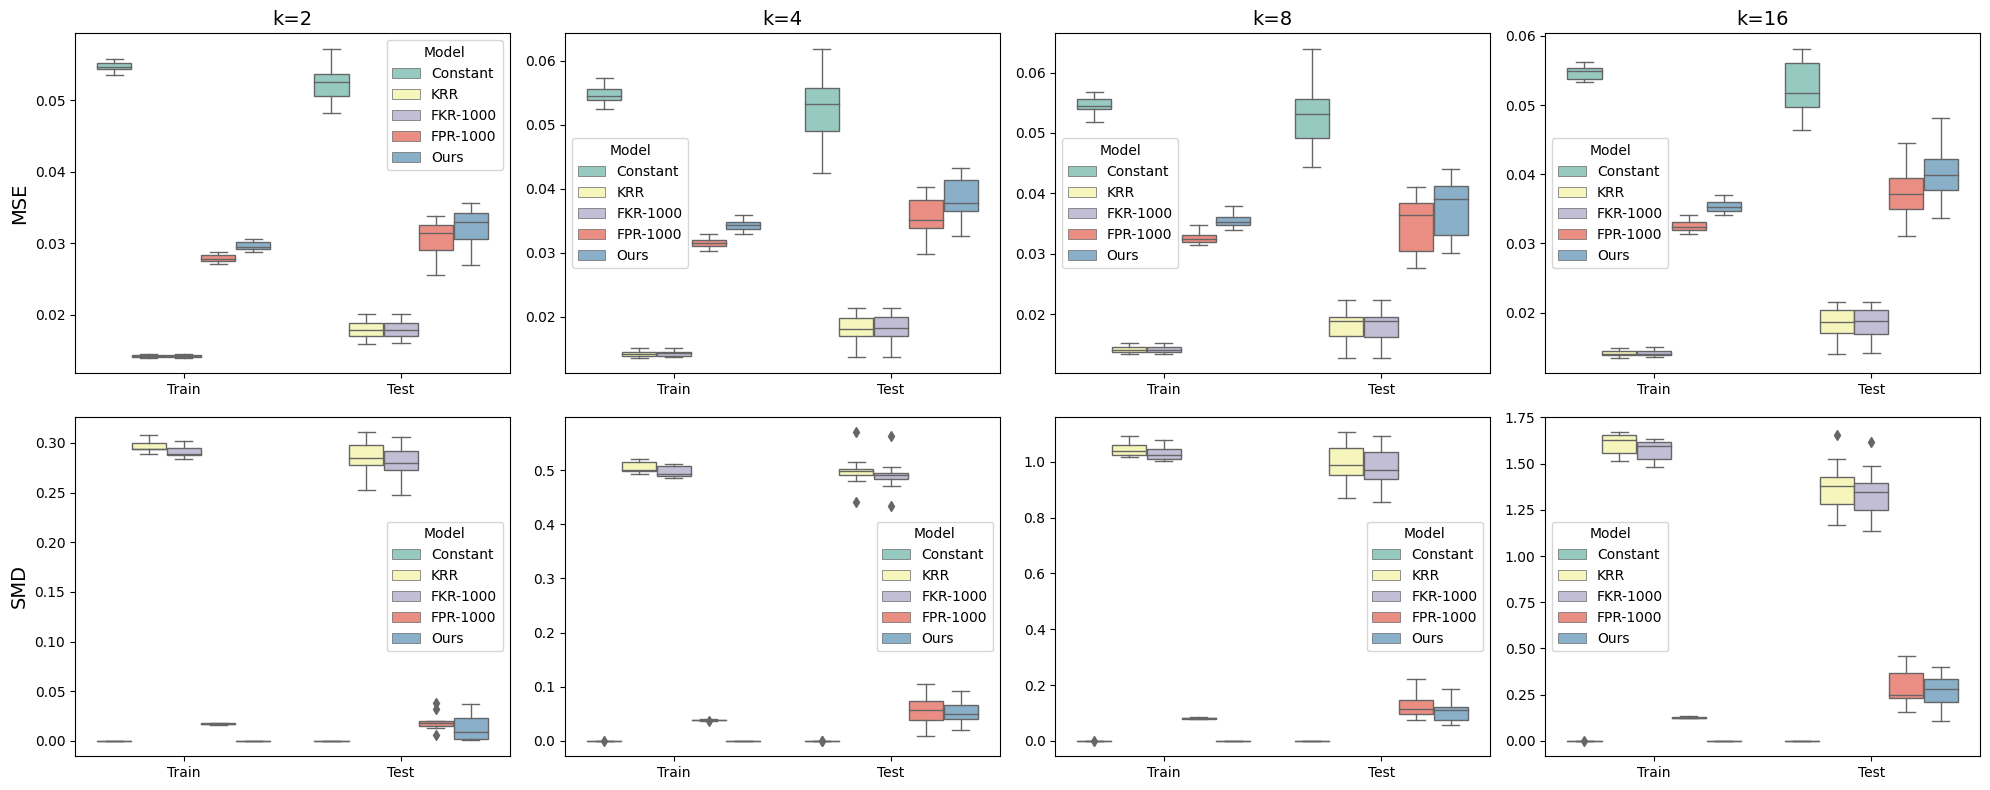

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
k_set=[2,4,8,16]
for i  in range(len(k_set)):
    ax = sns.boxplot(ax=axes[0,i], x="Mode", y="MSE", hue="Model",
             data=df[df.K==k_set[i]], palette="Set3",linewidth=1)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax = sns.boxplot(ax=axes[1,i], x="Mode", y="SMD", hue="Model",
             data=df[df.K==k_set[i]], palette="Set3",linewidth=1)
    ax.set_xlabel('')
    ax.set_ylabel('')
axes[0,0].set_ylabel('MSE', fontsize=14)
axes[1,0].set_ylabel('SMD',fontsize=14)
axes[0,0].set_title('k=2',fontsize=14)
axes[0,1].set_title('k=4',fontsize=14)
axes[0,2].set_title('k=8',fontsize=14)
axes[0,3].set_title('k=16',fontsize=14)
plt.tight_layout()